## 1. Preparation

**1.1 Import modules**

In [850]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='dark', palette='colorblind', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

**1.2 Read the file train.csv into Python and print a few rows.**

In [851]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [852]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. EDA

**2.1 Calculate the number of surviving/non-surviving passengers and display it as a bar plot.**

In [853]:
df.value_counts('Survived')

Survived
0    549
1    342
dtype: int64

In [854]:
survival = df.value_counts('Survived').reset_index()
survival.rename(columns={'Survived':'Status',0:'Number_of_people'}, inplace=True)
survival

,Status,Number_of_people
0,0,549
1,1,342


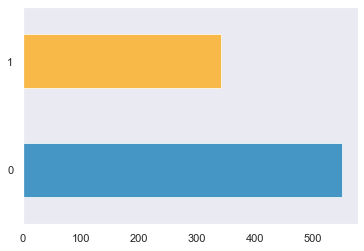

In [855]:
survival['Number_of_people'].plot.barh(alpha=0.7, color=['b', 'orange']);

Sadly, more people died than survived. Let's look at possible reasons for that.

**2.2 Calculate the proportion of surviving 1st class passengers with regards to the total number of 1st class passengers.**

In [856]:
class_survivors = pd.crosstab(df.Pclass, df.Survived)
class_survivors['Ratio'] = class_survivors[1]/(class_survivors[0] + class_survivors[1])

class_survivors.columns.name=''
class_survivors.reset_index(inplace=True)

class_survivors.rename(columns={0:'Drowned', 1:'Survivor'}, inplace=True)

class_survivors

,Pclass,Drowned,Survivor,Ratio
0,1,80,136,0.629630
1,2,97,87,0.472826
2,3,372,119,0.242363


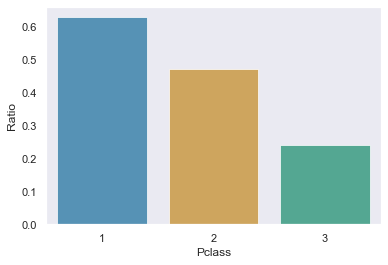

In [857]:
sns.barplot(data=class_survivors, y='Ratio', x='Pclass', alpha=0.7);

The ratio of people surviving in the first class is much higher. Quite telling already.

**2.3 Create a bar plot with separate bars for male/female passengers and 1st/2nd/3rd class passengers.**

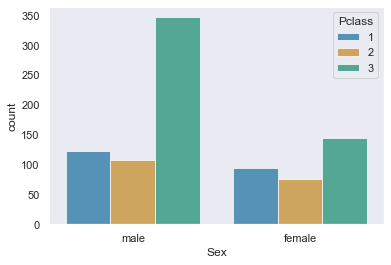

In [858]:
sns.countplot(data = df, x = 'Sex', hue= 'Pclass', alpha=0.7);                   

In [859]:
grouped_sex_class = df.groupby(['Pclass', 'Sex']).size().reset_index().pivot(columns='Sex', index='Pclass', values=0)
grouped_sex_class

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


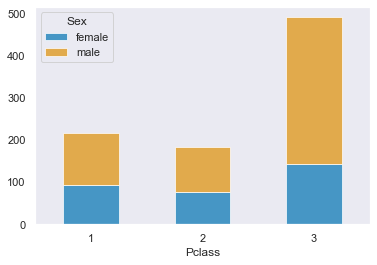

In [860]:
grouped_sex_class.plot.bar(alpha = 0.7, stacked=True)
plt.xticks(rotation=0);

**2.4. Create a histogram showing the age distribution of passengers. Compare surviving/non-surviving passengers.**

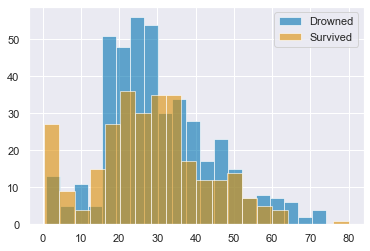

In [861]:
fig, ax = plt.subplots()
ax = df['Age'][df['Survived'] == 0].hist(bins=20, alpha=0.6, label='Drowned')
ax = df['Age'][df['Survived'] == 1].hist(bins=20, alpha=0.6, label='Survived')
plt.legend();

Survivors seemed to be slightly younger than the majority of people who drowned.

**2.5. Create a table counting the number of surviving/dead passengers separately for 1st/2nd/3rd class and male/female.**

In [862]:
ct_sex_status_class = pd.crosstab([df.Survived, df.Pclass], df.Sex)
ct_sex_status_class

Sex              female  male
Survived Pclass              
0        1            3    77
         2            6    91
         3           72   300
1        1           91    45
         2           70    17
         3           72    47

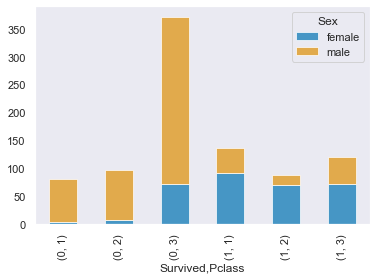

In [863]:
ct_sex_status_class.plot.bar(stacked=True, alpha=0.7);

**2.6 Calculate the average age for survived and drowned passengers separately.**

In [864]:
mean_age_survivors = round(df[df['Survived'] == 1].mean(numeric_only=True)['Age'],0)
mean_age_survivors

28.0

In [865]:
mean_age_drowned = round(df[df['Survived'] == 0].mean(numeric_only=True)['Age'], 0)
mean_age_drowned

31.0

## 3. First logistic regression

**3.1 Let's just run a logistic regression right now to get a baseline from which to improve our model. We'll use all numeric data we have right now**

In [866]:
df_subset = df[['Pclass', 'Fare', 'Survived','SibSp', 'Parch']]

In [867]:
df_subset.shape

(891, 5)

In [868]:
df_subset.describe()

,Pclass,Fare,Survived,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,32.204208,0.383838,0.523008,0.381594
std,0.836071,49.693429,0.486592,1.102743,0.806057
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,7.910400,0.000000,0.000000,0.000000
50%,3.000000,14.454200,0.000000,0.000000,0.000000
75%,3.000000,31.000000,1.000000,1.000000,0.000000
max,3.000000,512.329200,1.000000,8.000000,6.000000


In [869]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Fare      891 non-null    float64
 2   Survived  891 non-null    int64  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 41.8 KB


<AxesSubplot:>

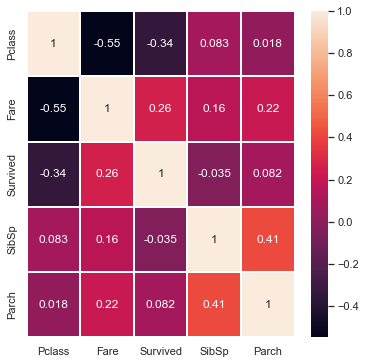

In [870]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(ax=ax, data=df_subset.corr(), annot=True, linewidths=0.2)

In [871]:
X_subset = df_subset[['Pclass', 'Fare','SibSp', 'Parch']]
y_subset = df_subset['Survived']

In [872]:
X_subset.shape, y_subset.shape

((891, 4), (891,))

**3.2. Define the train-test-split for this subset**

In [873]:
X_train, X_test, y_train, y_test = train_test_split(X_subset,y_subset, test_size = 0.2, random_state = 30)

**3.3 Define a baseline model**

In [874]:
dummy = DummyClassifier(strategy= 'most_frequent')

In [875]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [876]:
round(dummy.score(X_test, y_test),2)

0.6

Okay, so 60% is what our dummy model can achieve, we should be able to do better than that right from the start.

**3.4 Run our own logistic regression**

In [877]:
m_lr = LogisticRegression(class_weight='balanced')

In [878]:
m_lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [879]:
round(m_lr.score(X_train, y_train),2), round(m_lr.score(X_test, y_test),2)
#well, maybe right now we cannot do much better!

(0.67, 0.67)

In [880]:
m_lr.predict_proba(X_train)

array([[0.49134883, 0.50865117],
       [0.66502677, 0.33497323],
       [0.58077396, 0.41922604],
       ...,
       [0.62926917, 0.37073083],
       [0.66503556, 0.33496444],
       [0.66499193, 0.33500807]])

In [881]:
y_pred_test = m_lr.predict(X_test)
y_pred_train = m_lr.predict(X_train)

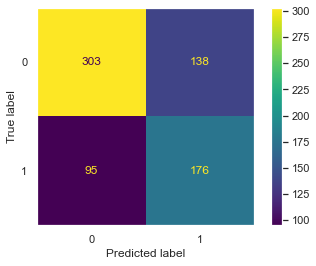

In [882]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize=None)

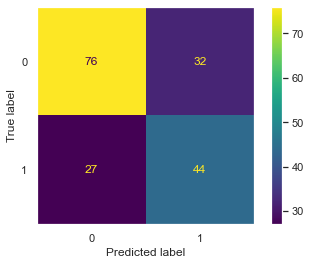

In [883]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize=None)

/Users/finngebauer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


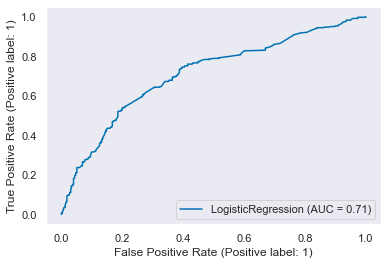

In [884]:
plot_roc_curve(m_lr, X_subset, y_subset);

This really is not looking too great with the low-ish AUC and the high number of FP and FN. We definitely need to work on the data to get better results.

## 4. Train/test split

Before we wrangle with the data, we split the data set to avoid data leakage

In [885]:
list(df.columns)

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [886]:
X=df[['Pclass',
     'Name',
     'Sex',
     'Age',
     'SibSp',
     'Parch',
     'Ticket',
     'Fare',
     'Cabin',
     'Embarked']]
y=df['Survived']
X.shape, y.shape

((891, 10), (891,))

In [887]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 30)

## 5. Feature engineering

**5.1 Replace missing values**

In [888]:
X_train['Age'].fillna(X_train.groupby(['Pclass', 'Sex'])['Age'].transform('mean').round(0), inplace=True)

X_test['Age'].fillna(X_test.groupby(['Pclass', 'Sex'])['Age'].transform('mean').round(0), inplace=True)

X_train.tail()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
141,3,"Boulos, Mrs. Joseph (Sultana)",female,21.0,0,2,2678,15.2458,NaN,C
501,3,"Calic, Mr. Petar",male,17.0,0,0,315086,8.6625,NaN,S
814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
422,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q
806,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,NaN,S


In [889]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train[['Embarked']])        
X_train['Embarked'] = imputer.transform(X_train[['Embarked']])

X_test['Embarked'] = imputer.transform(X_test[['Embarked']])

X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
704,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q
824,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S
237,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [890]:
X_train.isna().sum()
#Only Cabin values are left and we cannot really fill them. What if we used them in another way? Check 5.3 if you're curious!

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       553
Embarked      0
dtype: int64

**5.2 Binning and merging**

In [891]:
X_train['Age_bins'] = pd.cut(X_train.Age, bins=[0,19,36,61,81], labels = ['minor', 'young adult', 'adult', 'elder'])

X_test['Age_bins'] = pd.cut(X_test.Age, bins=[0,19,36,61,81], labels = ['minor', 'young adult', 'adult', 'elder'])

X_train.Age_bins.value_counts()

young adult    399
adult          160
minor          140
elder           13
Name: Age_bins, dtype: int64

In [892]:
X_train['Fare_bins'] = pd.cut(X_train.Fare, bins=[0, 15, 50, 100, 550], 
                              labels=['cheap', 'economy', 'business', 'high-end'])

X_test['Fare_bins'] = pd.cut(X_test.Fare, bins=[0, 15, 50, 100, 550], 
                              labels=['cheap', 'economy', 'business', 'high-end'])

X_train.Fare_bins.value_counts()

cheap       353
economy     223
business     82
high-end     44
Name: Fare_bins, dtype: int64

As we cannot differentiate between parent/children and sibling/spouse, we can merge these columns to have a family column

In [893]:
X_train['Family'] = X_train.SibSp + X_train.Parch
X_test['Family'] = X_test.SibSp + X_test.Parch

In [894]:
X_train.Family.max()

10

In [895]:
X_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
X_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [896]:
#And let's make bins for no, small and big families

X_train['Family_size'] = pd.cut(X_train.Family, bins=[0,0.5,3,11], labels=['No family', 'Small family', 'Big family'])
X_train['Family_size'] = np.where(X_train.Family_size.isnull(), 'No family', X_train.Family_size)

X_test['Family_size'] = pd.cut(X_test.Family, bins=[0,0.5,3,11], labels=['No family', 'Small family', 'Big family'])
X_test['Family_size'] = np.where(X_test.Family_size.isnull(), 'No family', X_test.Family_size)

X_train.Family_size

PassengerId
200       No family
704       No family
824    Small family
237    Small family
680    Small family
           ...     
141    Small family
501       No family
814      Big family
422       No family
806       No family
Name: Family_size, Length: 712, dtype: object

**5.3 make a binary out of the cabin values**

In [897]:
X_train['Cabin_status'] = np.where(X_train.Cabin.isnull(), 0, 1)

X_test['Cabin_status'] = np.where(X_test.Cabin.isnull(), 0, 1)
#While cabin location might matter, we don't know about it and thus stick with the ibinary

In [898]:
pd.crosstab(X_train.Cabin_status, X_train.Fare_bins)

Fare_bins,cheap,economy,business,high-end
Cabin_status,,,,
0,333,180,23,8
1,20,43,59,36


In [899]:
X_train.head()

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Age_bins,Fare_bins,Family,Family_size,Cabin_status
PassengerId,,,,,,,,,,,,,
200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,248747,13.0000,NaN,S,young adult,cheap,0,No family,0
704,3,"Gallagher, Mr. Martin",male,25.0,36864,7.7417,NaN,Q,young adult,cheap,0,No family,0
824,3,"Moor, Mrs. (Beila)",female,27.0,392096,12.4750,E121,S,young adult,cheap,1,Small family,1
237,2,"Hold, Mr. Stephen",male,44.0,26707,26.0000,NaN,S,adult,economy,1,Small family,0
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,PC 17755,512.3292,B51 B53 B55,C,young adult,high-end,1,Small family,1


**5.4 Encode categorical values and drop unnecessary ones**

In [900]:
X_train = X_train.join(pd.get_dummies
                       (X_train[['Sex', 'Embarked', 'Age_bins', 'Fare_bins', 'Family_size']], drop_first = True))

X_test = X_test.join(pd.get_dummies
                       (X_test[['Sex', 'Embarked', 'Age_bins', 'Fare_bins', 'Family_size']], drop_first = True))

In [901]:
X_train.head(2)

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Age_bins,Fare_bins,...,Embarked_Q,Embarked_S,Age_bins_young adult,Age_bins_adult,Age_bins_elder,Fare_bins_economy,Fare_bins_business,Fare_bins_high-end,Family_size_No family,Family_size_Small family
PassengerId,,,,,,,,,,,,,,,,,,,,,
200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,248747,13.0000,NaN,S,young adult,cheap,...,0,1,1,0,0,0,0,0,1,0
704,3,"Gallagher, Mr. Martin",male,25.0,36864,7.7417,NaN,Q,young adult,cheap,...,1,0,1,0,0,0,0,0,1,0


In [902]:
X_test.head()

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Age_bins,Fare_bins,...,Embarked_Q,Embarked_S,Age_bins_young adult,Age_bins_adult,Age_bins_elder,Fare_bins_economy,Fare_bins_business,Fare_bins_high-end,Family_size_No family,Family_size_Small family
PassengerId,,,,,,,,,,,,,,,,,,,,,
418,2,"Silven, Miss. Lyyli Karoliina",female,18.0,250652,13.00,NaN,S,minor,cheap,...,0,1,0,0,0,0,0,0,0,1
308,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,PC 17758,108.90,C65,C,minor,high-end,...,0,0,0,0,0,0,0,1,0,1
88,3,"Slocovski, Mr. Selman Francis",male,28.0,SOTON/OQ 392086,8.05,NaN,S,young adult,cheap,...,0,1,1,0,0,0,0,0,1,0
578,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,13507,55.90,E44,S,adult,business,...,0,1,0,1,0,0,1,0,0,1
685,2,"Brown, Mr. Thomas William Solomon",male,60.0,29750,39.00,NaN,S,adult,economy,...,0,1,0,1,0,1,0,0,0,1


In [903]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked',
       'Age_bins', 'Fare_bins', 'Family', 'Family_size', 'Cabin_status',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_bins_young adult',
       'Age_bins_adult', 'Age_bins_elder', 'Fare_bins_economy',
       'Fare_bins_business', 'Fare_bins_high-end', 'Family_size_No family',
       'Family_size_Small family'],
      dtype='object')

In [904]:
X_test.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked',
       'Age_bins', 'Fare_bins', 'Family', 'Family_size', 'Cabin_status',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_bins_young adult',
       'Age_bins_adult', 'Age_bins_elder', 'Fare_bins_economy',
       'Fare_bins_business', 'Fare_bins_high-end', 'Family_size_No family',
       'Family_size_Small family'],
      dtype='object')

In [905]:
#We'll lose the Name and Ticket columns as well as all columns that we have binned and encoded
X_train = X_train[['Pclass', 'Cabin_status',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_bins_young adult',
       'Age_bins_adult', 'Age_bins_elder', 'Fare_bins_economy',
       'Fare_bins_business', 'Fare_bins_high-end', 'Family_size_No family',
       'Family_size_Small family']]

X_test = X_test[['Pclass','Cabin_status',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_bins_young adult',
       'Age_bins_adult', 'Age_bins_elder', 'Fare_bins_economy',
       'Fare_bins_business', 'Fare_bins_high-end', 'Family_size_No family',
       'Family_size_Small family']]

**5.5 Time for a quick heatmap to check for possible correlations**

<AxesSubplot:>

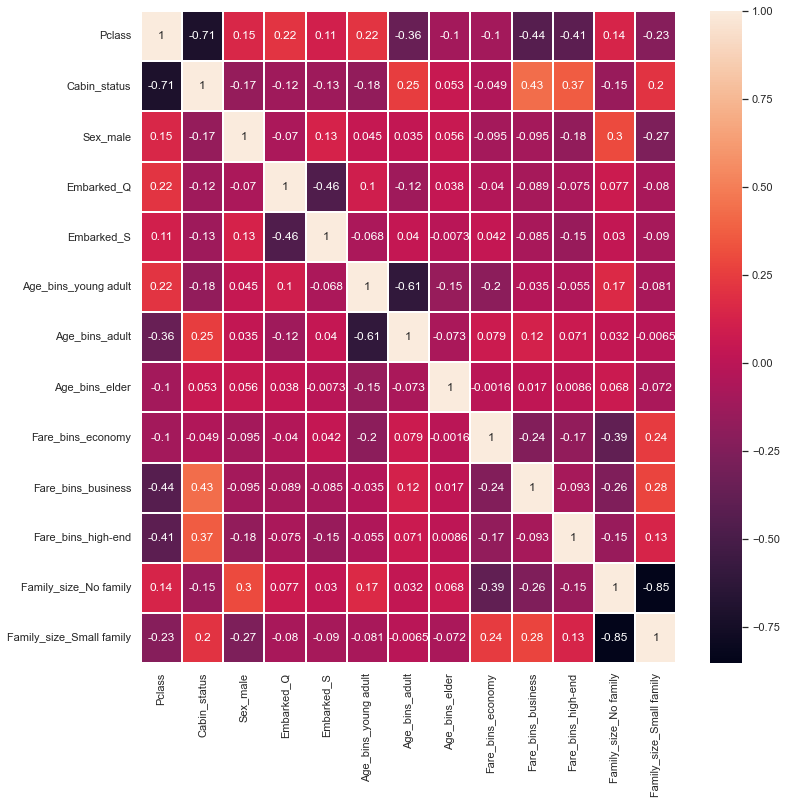

In [906]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(ax=ax, data=X_train.corr(), annot=True, linewidths=0.2)

## 6. Second logistic regression

**6.1 Run the LogReg model**

In [907]:
m_lr2 = LogisticRegression()

In [908]:
m_lr2.fit(X_train, y_train)

LogisticRegression()

In [909]:
round(m_lr2.score(X_train, y_train),2), round(m_lr2.score(X_test, y_test),2)

(0.82, 0.8)

**6.2 Calculate the train and validation accuracy**

In [910]:
y_pred_test = m_lr2.predict(X_test)
y_pred_train = m_lr2.predict(X_train)

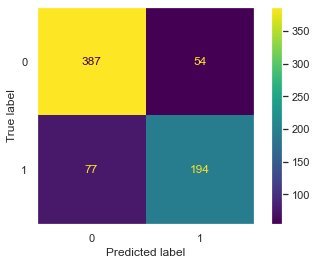

In [911]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize=None)

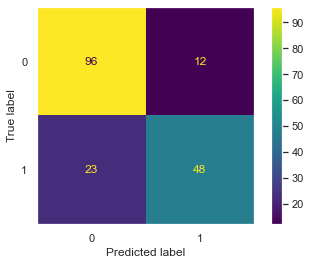

In [912]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize=None)

In [913]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       441
           1       0.78      0.72      0.75       271

    accuracy                           0.82       712
   macro avg       0.81      0.80      0.80       712
weighted avg       0.81      0.82      0.81       712



In [914]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       108
           1       0.80      0.68      0.73        71

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



/Users/finngebauer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


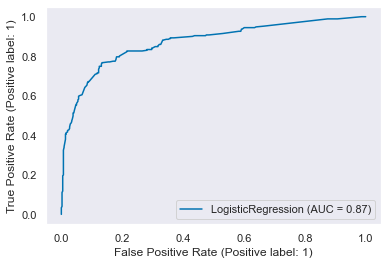

In [915]:
plot_roc_curve(m_lr2, X_train, y_train)

Alright, this is looking much better but let's look at other models, first, it's time to wander into the woods.

## 7. Random Forest

**7.1 Run the model**

In [916]:
m_rf = RandomForestClassifier(n_estimators=100, max_depth=5)

In [917]:
m_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5)

In [918]:
round(m_rf.score(X_train, y_train), 2), round(m_rf.score(X_test, y_test),2)

(0.83, 0.8)

**7.2 Calculate the train and validation accuracy**

In [919]:
y_pred_test = m_rf.predict(X_test)
y_pred_train = m_rf.predict(X_train)

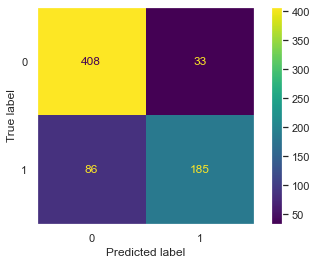

In [920]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize=None)

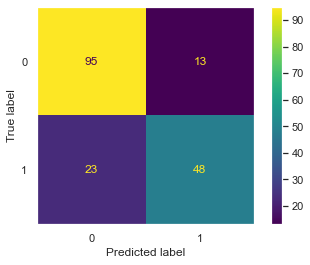

In [921]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize=None)

In [922]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87       441
           1       0.85      0.68      0.76       271

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.81       712
weighted avg       0.83      0.83      0.83       712



In [923]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       108
           1       0.79      0.68      0.73        71

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



/Users/finngebauer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


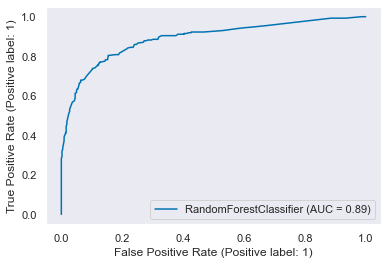

In [924]:
plot_roc_curve(m_rf, X_train, y_train)

The current hyperparameters give us a well-performing and stable model. We'll run two more models against this.

## 8. Support vector machines

**8.1 Run the model**

In [925]:
m_svc = SVC(kernel='rbf', C=0.1)
m_svc.fit(X_train, y_train)
round(m_svc.score(X_train, y_train),2), round(m_svc.score(X_test, y_test),2)

(0.82, 0.75)

**8.2 Calculate the train and validation accuracy**

In [926]:
y_pred_test = m_svc.predict(X_test)
y_pred_train = m_svc.predict(X_train)

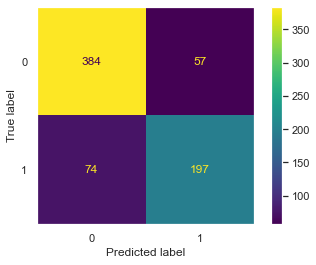

In [927]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize=None)

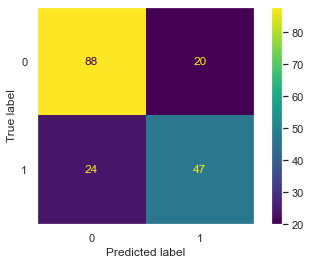

In [928]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize=None)

In [929]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       441
           1       0.78      0.73      0.75       271

    accuracy                           0.82       712
   macro avg       0.81      0.80      0.80       712
weighted avg       0.81      0.82      0.81       712



In [930]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       108
           1       0.70      0.66      0.68        71

    accuracy                           0.75       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



/Users/finngebauer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


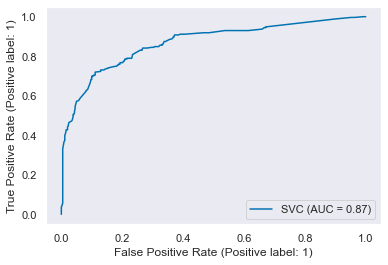

In [931]:
plot_roc_curve(m_svc, X_train, y_train)

The SVC seems to perform similarly to the LogReg model with the rbf hyperparameter. Lastly, we'll check how a ensemble model performs.

## 9. Ensemble model

**9.1 Run the model**

In [932]:
models = [
          ('logreg', LogisticRegression()),
          ('random_forest', RandomForestClassifier(n_estimators=1000, max_depth=3)),
          ('svm', SVC(kernel='rbf', C=0.1))]

m_ens = VotingClassifier(models)

m_ens.fit(X_train, y_train)
round(m_ens.score(X_train, y_train),2), round(m_ens.score(X_test, y_test),2)

(0.82, 0.78)

**9.2 Calculate the train and validation accuracy**

In [933]:
y_pred_test = m_ens.predict(X_test)
y_pred_train = m_ens.predict(X_train)

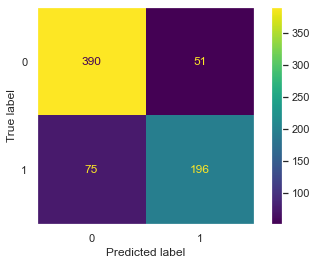

In [934]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize=None)

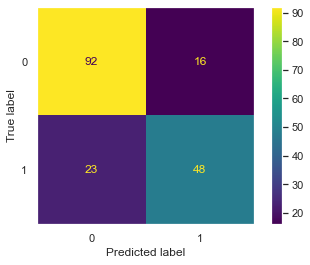

In [935]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize=None)

In [936]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       441
           1       0.79      0.72      0.76       271

    accuracy                           0.82       712
   macro avg       0.82      0.80      0.81       712
weighted avg       0.82      0.82      0.82       712



In [937]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       108
           1       0.75      0.68      0.71        71

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



## 10. Summary

As expected, the ensemble model performs very well, however, the single models perform equally as well and are easier to understand. Random Forest has the best results, however, the logistic regression is a simpler model and gets very close.

What could we do better? There is likely information in the 'Ticket' (e.g. people that travel together) and 'Name'(perhaps name length could be an indicator?) columns. Additionally, scaling instead of binning our fare values could provide us with a more robust model that is not biased by my bins. Lastly, the cabin values might contain more information. Considering the number of non-null values in there, I doubt that it would improve the model by much.